<a href="https://colab.research.google.com/github/Chiosas/Keypoints/blob/master/Apparel_Keypoints_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'keypoints'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

if IN_COLAB and FIRST_RUN:
    !pip install -q -U --pre efficientnet

### ***Data Download***

In [0]:
DRIVE_DIR = Path('drive/My Drive/Capstone')

In [0]:
import shutil

if IN_COLAB and FIRST_RUN:
    archive_files = [
        'fashionAI_keypoints_train1.tar',
        'fashionAI_keypoints_train2.tar',
        'fashionAI_keypoints_test.tar',
    ]
    for filename in archive_files:
        shutil.unpack_archive(DRIVE_DIR/filename, DATA_DIR, 'tar')

In [0]:
if IN_COLAB and FIRST_RUN:
    for folder in os.listdir(DATA_DIR):
        place = folder if folder == 'test' else folder[:-1]
        for folder_name in os.listdir(DATA_DIR/folder/'Images'):
            shutil.move(DATA_DIR/folder/'Images'/folder_name, DATA_DIR/place/folder_name)
        shutil.move(DATA_DIR/folder/f'{place}.csv', DATA_DIR/place/(f'{folder}.csv'))
        if folder == 'test':
            shutil.rmtree(DATA_DIR/folder/'Images')
        else:
            shutil.rmtree(DATA_DIR/folder)

### ***Importing Dependencies***

In [8]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras

TensorFlow 2.x selected.


In [9]:
tf.__version__

'2.1.0'

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import efficientnet.tfkeras as efn

import PIL
import math
import pickle

from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***

### ***Content - Apparel Keypoints Dataset***


**Introduction**

Machine analysis of apparel could easily be affected by the dimension and shape of clothes, the distance and angle of camera shooting, and even how the apparel is displayed or the model is posing. Detection of apparel keypoints in images can help to improve the performance of applications such as alignment of clothes, recognition of clothes local attributes and auto-editing of apparel images.

We provide a dataset for key point localization of the apparel in practical scenarios. In this dataset, a set of clothing keypoints is defined on the basis of fashion design. The set is further refined into six subsets according to the following six women apparel categories: blouse, outwear, trousers, skirt, dress and jumpsuit, respectively. Currently, the dataset of the first five categories is open for download (the jumpsuit category is omitted since it is uncommon in the real-world scenario), including 41 sub-categories and 24 kinds of keypoints in total. There are altogether 100,000 annotated images in this dataset.


![Key_Points](https://work.alibaba-inc.com/aliwork_tfs/g01_alibaba-inc_com/tfscom/TB16Z8fXQCWBuNjy0FaXXXUlXXa.tfsprivate.jpg)


**Data Description**

*Image data*

All image data are from Alibaba e-Commerce platform. We randomly collected data with the following three standards:
1) The images fall into the five aforementioned categories as evenly as possible;
2) There are approximately an even number of single-model images and tiled single-piece images;
3) There are approximately an even number of simple-background and complex-background images.

*Keypoint Definition*

There are totally 24 type of keypoints, but not every cloth category needs to cover all those keypoints. For example, there are only 7 keypoints in trousers, with other keypoints inexistent, such as left/right necklines.

*Annotation Format*

Annotation file is saved in a csv-format table with a total of 26 columns: the first column (image_id) contains image file name, the second column (image_category) denotes the category that an image belongs to, and the remaining 24 columns record the positions of the aforementioned 24 keypoints, respectively.

Each keypoint is represented by a triple whoes elements are connected by underscores, denoted as "x_y_v", where the x and y are coordinates, and v is visibility. Visibility equals 1 if a keypoint is visible, 0 if it is occluded, and -1 if it is inexistent or undefined in the category.

*Training Data*

One folder and an annotation file can be found after decompressing the training data package.
- *Images* folder contains test images in jpeg format.
- *train.csv* contains annotation of training images. 


###***Making Image Dataframes***

In [0]:
# Setting folder names for train and test data
train_dir = 'train'
test_dir = 'test'

In [0]:
# Reading the data from the file
train1_data = pd.read_csv(DATA_DIR/train_dir/'train1.csv', low_memory=False)
train2_data = pd.read_csv(DATA_DIR/train_dir/'train2.csv', low_memory=False)

raw_data = pd.concat([train1_data, train2_data])

In [15]:
raw_data.head(2).T

0                                                  1
image_id          Images/blouse/0003e38fe17e564f49e1ccef5020d269...  Images/blouse/00043c6d051d3469b38b6cd203f5622c...
image_category                                               blouse                                             blouse
neckline_left                                             229_121_1                                          200_161_1
neckline_right                                            282_117_1                                          323_156_1
center_front                                              256_138_1                                          262_183_1
shoulder_left                                             177_170_1                                          192_169_1
shoulder_right                                            337_148_1                                          327_168_1
armpit_left                                               201_236_1                                          191_202_0
armpit_right                                              328_226_1                                          336_207_0
waistline_left                                             -1_-1_-1                                           -1_-1_-1
waistline_right                                            -1_-1_-1                                           -1_-1_-1
cuff_left_in                                              190_374_1                                          191_424_1
cuff_left_out                                             170_383_1                                          151_424_1
cuff_right_in                                             334_371_1                                          339_423_1
cuff_right_out                                            354_377_1                                          370_422_1
top_hem_left                                              183_432_0                                          174_353_1
top_hem_right                                             341_417_0                                          344_354_1
waistband_left                                             -1_-1_-1                                           -1_-1_-1
waistband_right                                            -1_-1_-1                                           -1_-1_-1
hemline_left                                               -1_-1_-1                                           -1_-1_-1
hemline_right                                              -1_-1_-1                                           -1_-1_-1
crotch                                                     -1_-1_-1                                           -1_-1_-1
bottom_left_in                                             -1_-1_-1                                           -1_-1_-1
bottom_left_out                                            -1_-1_-1                                           -1_-1_-1
bottom_right_in                                            -1_-1_-1                                           -1_-1_-1
bottom_right_out                                           -1_-1_-1                                           -1_-1_-1

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76866 entries, 0 to 32142
Data columns (total 26 columns):
image_id            76866 non-null object
image_category      76866 non-null object
neckline_left       76866 non-null object
neckline_right      76866 non-null object
center_front        76866 non-null object
shoulder_left       76866 non-null object
shoulder_right      76866 non-null object
armpit_left         76866 non-null object
armpit_right        76866 non-null object
waistline_left      76866 non-null object
waistline_right     76866 non-null object
cuff_left_in        76866 non-null object
cuff_left_out       76866 non-null object
cuff_right_in       76866 non-null object
cuff_right_out      76866 non-null object
top_hem_left        76866 non-null object
top_hem_right       76866 non-null object
waistband_left      76866 non-null object
waistband_right     76866 non-null object
hemline_left        76866 non-null object
hemline_right       76866 non-null object
crotch   

In [17]:
raw_data.describe(include='all').T

count  ...   freq
image_id          76866  ...      1
image_category    76866  ...  16613
neckline_left     76866  ...  32234
neckline_right    76866  ...  32232
center_front      76866  ...  46395
shoulder_left     76866  ...  34444
shoulder_right    76866  ...  34474
armpit_left       76866  ...  32304
armpit_right      76866  ...  32317
waistline_left    76866  ...  64517
waistline_right   76866  ...  64508
cuff_left_in      76866  ...  36721
cuff_left_out     76866  ...  36666
cuff_right_in     76866  ...  36735
cuff_right_out    76866  ...  36662
top_hem_left      76866  ...  46191
top_hem_right     76866  ...  46204
waistband_left    76866  ...  44782
waistband_right   76866  ...  44786
hemline_left      76866  ...  46620
hemline_right     76866  ...  46716
crotch            76866  ...  61248
bottom_left_in    76866  ...  61264
bottom_left_out   76866  ...  61295
bottom_right_in   76866  ...  61268
bottom_right_out  76866  ...  61298

[26 rows x 4 columns]

In [0]:
image_data = raw_data.copy()

In [0]:
class KeyPoint:
    '''
    Apparel Key Point class represented by data elements where the x and y are coordinates, p is presence and v is visibility
    '''

    def __init__(self, x_coord=None, y_coord=None, visible=None, present=None):
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.visible = visible
        self.present = present
    
    def __repr__(self):
        return (f'{self.__class__.__name__}('
                f'{self.x_coord!r}, {self.y_coord!r}, '
                f'{self.visible!r}, {self.present!r})')
    
    def __str__(self):
        return f'Coordinates (x, y): {self.x_coord}, {self.y_coord}; Visible: {bool(self.visible)}; Present: {bool(self.present)}'

In [0]:
def read_annotation(anno):
    '''
    Keypoint annotation is represented as "x_y_v", where the x and y are coordinates, and v is visibility
    '''
    x, y, v = map(int, anno.split(sep='_'))
    keypoint = KeyPoint(x, y, int(v > 0), int(v >= 0))
    
    return keypoint

In [0]:
def update_image_df(image_df, anno_cols):
    image_df['Image'] = image_df['image_id'].apply(lambda x: x.split(sep='/')[-1])
    image_df['Path'] = image_df['image_id'].apply(lambda x: str(DATA_DIR/train_dir/x.split(sep='/')[1]))
    image_df['Image_Path'] = image_df['Path'] + '/' + image_df['Image']

    image_df['Image_Dims'] = image_df['Image_Path'].apply(lambda x: PIL.Image.open(x).size)
    image_df['Image_Width'] = image_df['Image_Dims'].apply(lambda x: x[0])
    image_df['Image_Height'] = image_df['Image_Dims'].apply(lambda x: x[1])

    for col in anno_cols:
        image_df[f'{col}_kp'] = image_df[col] != '-1_-1_-1'

    anno_cols_kp = [f'{col}_kp' for col in anno_cols]
    image_df['Point_Count'] = image_df[anno_cols_kp].sum(axis=1)

    for col in anno_cols:
        image_df[f'{col}_obj'] = image_df[col].apply(read_annotation)

    return image_df

In [22]:
anno_cols = list(image_data.columns)[2:]
image_data = update_image_df(image_data, anno_cols)
image_data = image_data.drop(columns=anno_cols)
image_data.head(2).T

0                                                  1
image_id              Images/blouse/0003e38fe17e564f49e1ccef5020d269...  Images/blouse/00043c6d051d3469b38b6cd203f5622c...
image_category                                                   blouse                                             blouse
Image                              0003e38fe17e564f49e1ccef5020d269.jpg               00043c6d051d3469b38b6cd203f5622c.jpg
Path                                        data/keypoints/train/blouse                        data/keypoints/train/blouse
Image_Path            data/keypoints/train/blouse/0003e38fe17e564f49...  data/keypoints/train/blouse/00043c6d051d3469b3...
Image_Dims                                                   (512, 512)                                         (512, 512)
Image_Width                                                         512                                                512
Image_Height                                                        512                                                512
neckline_left_kp                                                   True                                               True
neckline_right_kp                                                  True                                               True
center_front_kp                                                    True                                               True
shoulder_left_kp                                                   True                                               True
shoulder_right_kp                                                  True                                               True
armpit_left_kp                                                     True                                               True
armpit_right_kp                                                    True                                               True
waistline_left_kp                                                 False                                              False
waistline_right_kp                                                False                                              False
cuff_left_in_kp                                                    True                                               True
cuff_left_out_kp                                                   True                                               True
cuff_right_in_kp                                                   True                                               True
cuff_right_out_kp                                                  True                                               True
top_hem_left_kp                                                    True                                               True
top_hem_right_kp                                                   True                                               True
waistband_left_kp                                                 False                                              False
waistband_right_kp                                                False                                              False
hemline_left_kp                                                   False                                              False
hemline_right_kp                                                  False                                              False
crotch_kp                                                         False                                              False
bottom_left_in_kp                                                 False                                              False
bottom_left_out_kp                                                False                                              False
bottom_right_in_kp                                                False                                              False
bottom_right_out_kp                                               False                                              False
Point_Count

###***Exploring Image Data***

In [23]:
# Shape of image dataframe
print('Number of rows in the dataset:', image_data.shape[0])
print('Number of columns in the dataset:', image_data.shape[1])

Number of rows in the dataset: 76866
Number of columns in the dataset: 57


In [0]:
# Column names to explore
img_h_col = 'Image_Height'
img_w_col = 'Image_Width'
class_col = 'image_category'
record_col = 'Image'

In [25]:
# Number of Classes
class_num = image_data[class_col].nunique()
class_num

5

In [26]:
# Image count by Class
image_data[class_col].value_counts().sort_values(ascending=False)

blouse      16613
skirt       16522
trousers    15621
outwear     14167
dress       13943
Name: image_category, dtype: int64

In [0]:
def img_bar_plot(data_df, feature, target):
    # Counting feature instances by target class
    class_df = data_df[[feature, target]].groupby(target, as_index=False).count()
    class_df = class_df.sort_values(by=feature, ascending=False).reset_index(drop=True)
    order_labels = list(class_df[target])

    # Setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 0.75 * class_df[target].nunique()))

    # Rendering plot
    sns.barplot(x=feature, y=target, data=class_df, edgecolor='black', orient='h', order=order_labels)

    # Adding chart title
    plt.title('Number of Records per Class', size=14)

    # Adding custom labels for axes
    plt.ylabel('Class')
    plt.xlabel('# of Records')

    # Adding labels on data points
    for index, row in class_df.iterrows():
        plt.text(row[feature] + class_df[feature].max() * 0.05, index, f'{row[feature]}', color='black', ha="center", size=11)

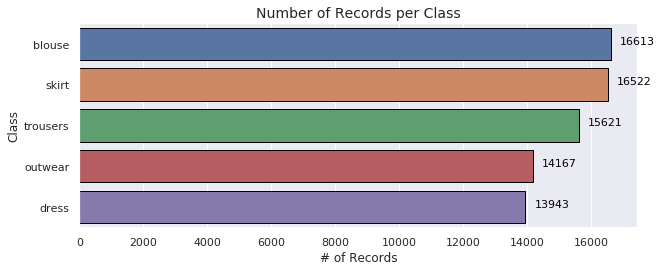

In [28]:
img_bar_plot(image_data, record_col, class_col)

In [0]:
def imgdims_scatter_plot(data_df, height, width, image):
    # Getting image dimensions
    img_dims_df = data_df[[image, height, width]]

    # Setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 4))

    # Rendering plot
    sns.scatterplot(x=width, y=height, hue=image, data=img_dims_df)

    # Adding chart title
    plt.title('Image dimensions variance', size=14)

    # Adding custom labels for axes
    plt.ylabel('Image Height')
    plt.xlabel('Image Width')

    # Adding custom legend title
    plt.legend(title='Class')

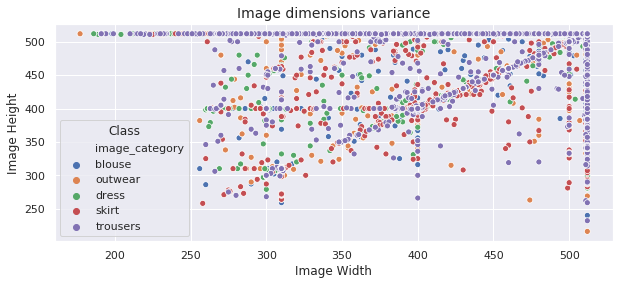

In [30]:
imgdims_scatter_plot(image_data, img_h_col, img_w_col, class_col)

In [31]:
# Variation of image dimensions
print(f"Image dimensions vary from {image_data[img_h_col].min()} to {image_data[img_h_col].max()} pixels in height.")
print(f"And from {image_data[img_w_col].min()} to {image_data[img_w_col].max()} pixels in width.")

Image dimensions vary from 216 to 512 pixels in height.
And from 177 to 512 pixels in width.


###***Exploring Keypoint Data***

In [0]:
kp_cnt_col = 'Point_Count'
path_col = 'Image_Path'

anno_cols_kp = [f'{col}_kp' for col in anno_cols]
anno_cols_obj = [f'{col}_obj' for col in anno_cols]

In [33]:
pd.DataFrame(image_data[class_col].value_counts().sort_index()).T

blouse  dress  outwear  skirt  trousers
image_category   16613  13943    14167  16522     15621

In [34]:
image_data[anno_cols_kp + [class_col]].groupby(class_col).sum().astype('int').T

image_category       blouse  dress  outwear  skirt  trousers
neckline_left_kp      16578  13907    14147      0         0
neckline_right_kp     16578  13911    14145      0         0
center_front_kp       16567  13904        0      0         0
shoulder_left_kp      15786  12515    14121      0         0
shoulder_right_kp     15759  12517    14116      0         0
armpit_left_kp        16554  13892    14116      0         0
armpit_right_kp       16551  13886    14112      0         0
waistline_left_kp         0   9879     2470      0         0
waistline_right_kp        0   9885     2473      0         0
cuff_left_in_kp       15983  10408    13754      0         0
cuff_left_out_kp      15942  10564    13694      0         0
cuff_right_in_kp      15972  10407    13752      0         0
cuff_right_out_kp     15951  10560    13693      0         0
top_hem_left_kp       16568      0    14107      0         0
top_hem_right_kp      16563      0    14099      0         0
waistband_left_kp         0      0        0  16501     15583
waistband_right_kp        0      0        0  16495     15585
hemline_left_kp           0  13829        0  16417         0
hemline_right_kp          0  13844        0  16306         0
crotch_kp                 0      0        0      0     15618
bottom_left_in_kp         0      0        0      0     15602
bottom_left_out_kp        0      0        0      0     15571
bottom_right_in_kp        0      0        0      0     15598
bottom_right_out_kp       0      0        0      0     15568

In [0]:
def kp_bar_plot(data_df, feature, target, category):
    # Counting feature instances by target class
    class_df = data_df[[feature, target]].groupby(target, as_index=False).count()
    class_df = class_df.sort_values(by=feature, ascending=False).reset_index(drop=True)
    order_labels = list(class_df[target])

    # Setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 0.75 * class_df[target].nunique()))

    # Rendering plot
    sns.barplot(x=feature, y=target, data=class_df, edgecolor='black', orient='h', order=order_labels)

    # Adding chart title
    plt.title(f'Number of Records per Class - {category.title()}', size=14)

    # Adding custom labels for axes
    plt.ylabel('# of Keypoints')
    plt.xlabel('# of Records')

    # Adding labels on data points
    for index, row in class_df.iterrows():
        plt.text(row[feature] + class_df[feature].max() * 0.05, index, f'{row[feature]}', color='black', ha="center", size=11)

In [0]:
def plot_dataframe(data, rows, cols):
    item_num = rows * cols
    data = data.sample(item_num).copy().reset_index()
    _, ax = plt.subplots(rows, cols, figsize=(4.75 * cols, 4.75 * rows))

    for i in range(item_num):
        image = PIL.Image.open(data.at[i, path_col])
        category = data.at[i, class_col]
        keypoints = np.array(data.loc[i, anno_cols_obj])

        idx = i // cols, i % cols if rows > 1 else i % cols
        ax[idx].axis('off')
        ax[idx].set_title(f'Class - {category.title()}')
        ax[idx].imshow(image)
        for point in keypoints:
            if point.present:
                color = 'ro' if point.visible else 'bo'
                ax[idx].plot(
                    point.x_coord, point.y_coord,
                    color, markersize=10, markeredgecolor='k'
                )

In [37]:
classes = image_data[class_col].unique()
classes

array(['blouse', 'outwear', 'dress', 'skirt', 'trousers'], dtype=object)

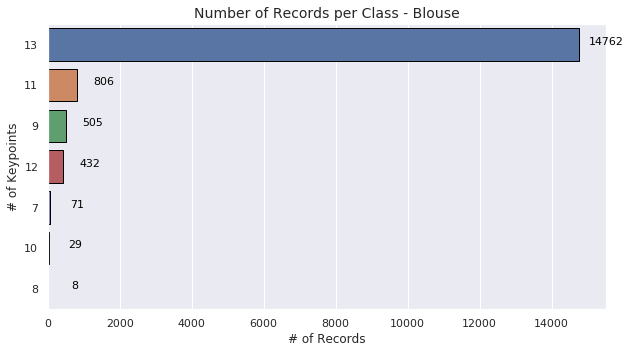

In [38]:
item_class = 'blouse'
kp_bar_plot(image_data[image_data[class_col] == item_class], record_col, kp_cnt_col, item_class)

In [39]:
class_data = image_data[(image_data[class_col] == item_class) & (image_data[kp_cnt_col] != 13)]
class_data.shape

(1851, 57)

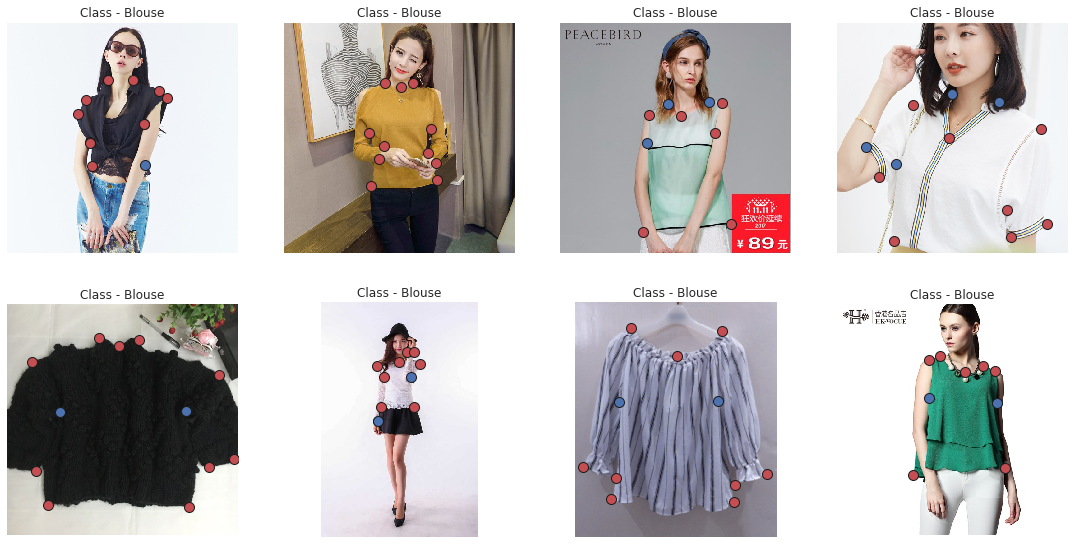

In [40]:
plot_dataframe(class_data, 2, 4)

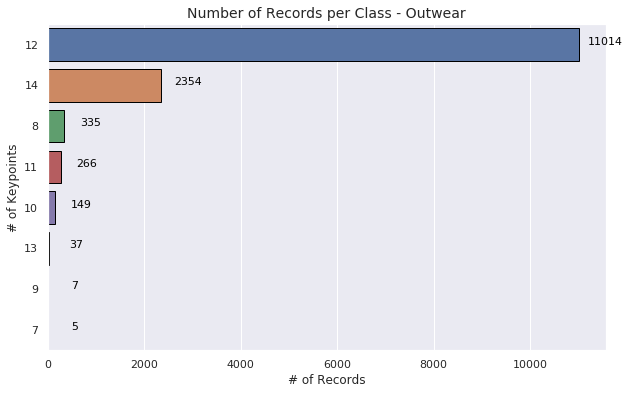

In [41]:
item_class = 'outwear'
kp_bar_plot(image_data[image_data[class_col] == item_class], record_col, kp_cnt_col, item_class)

In [42]:
class_data = image_data[(image_data[class_col] == item_class) & (image_data[kp_cnt_col] != 12)]
class_data.shape

(3153, 57)

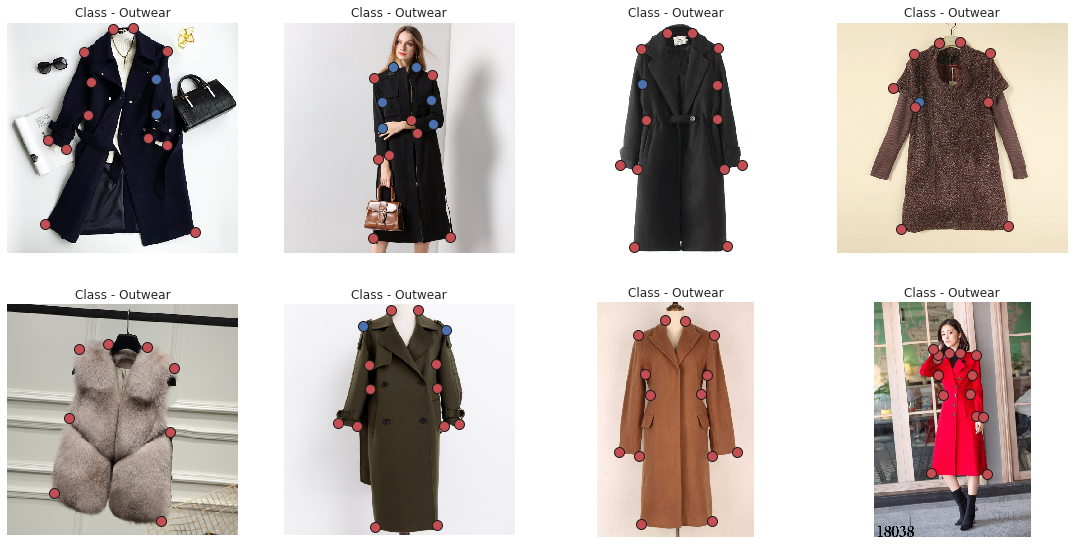

In [43]:
plot_dataframe(class_data, 2, 4)

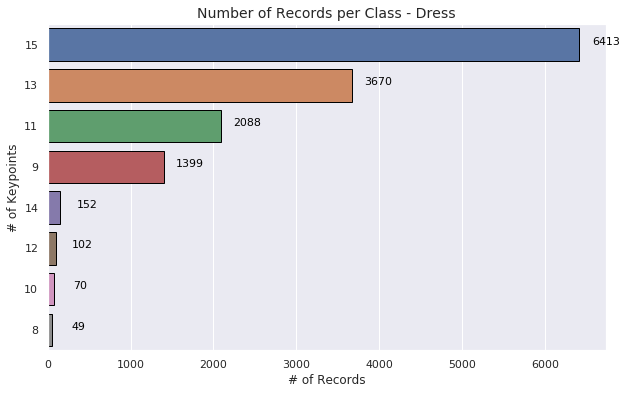

In [44]:
item_class = 'dress'
kp_bar_plot(image_data[image_data[class_col] == item_class], record_col, kp_cnt_col, item_class)

In [45]:
class_data = image_data[(image_data[class_col] == item_class) & (image_data[kp_cnt_col] % 2 == 0)]
class_data.shape

(373, 57)

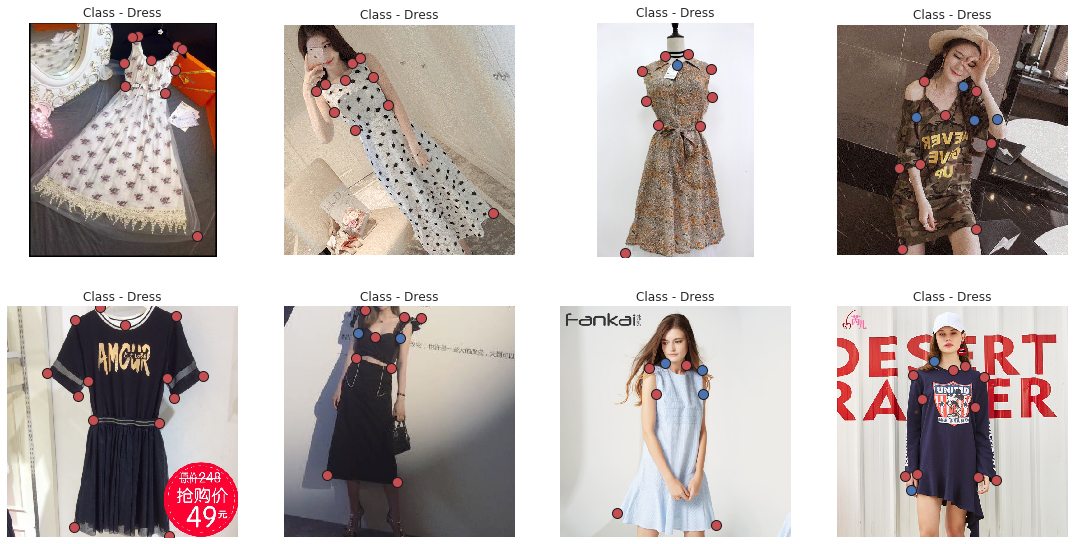

In [46]:
plot_dataframe(class_data, 2, 4)

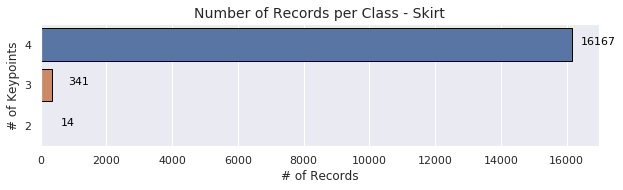

In [47]:
item_class = 'skirt'
kp_bar_plot(image_data[image_data[class_col] == item_class], record_col, kp_cnt_col, item_class)

In [48]:
class_data = image_data[(image_data[class_col] == item_class) & (image_data[kp_cnt_col] < 4)]
class_data.shape

(355, 57)

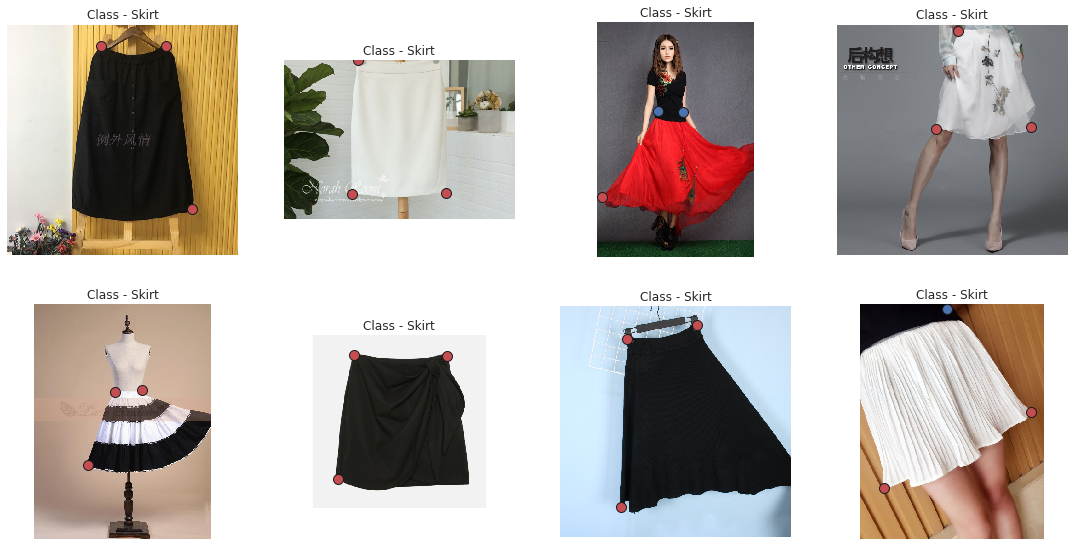

In [49]:
plot_dataframe(class_data, 2, 4)

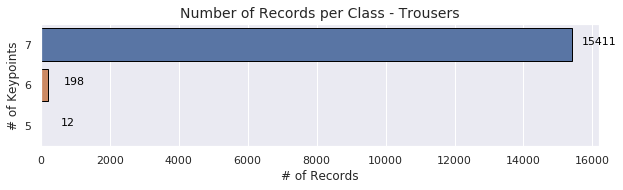

In [50]:
item_class = 'trousers'
kp_bar_plot(image_data[image_data[class_col] == item_class], record_col, kp_cnt_col, item_class)

In [51]:
class_data = image_data[(image_data[class_col] == item_class) & (image_data[kp_cnt_col] < 7)]
class_data.shape

(210, 57)

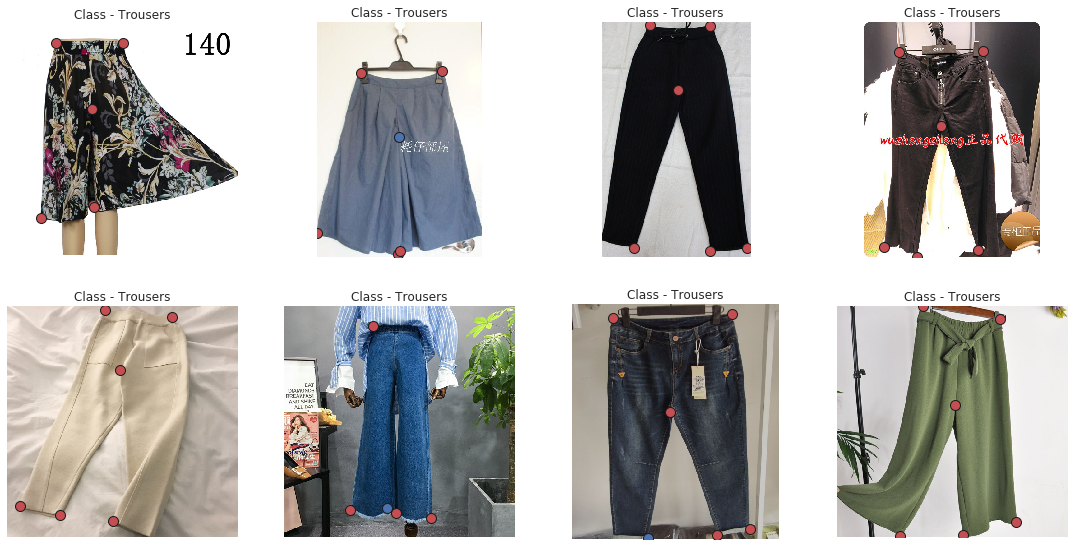

In [52]:
plot_dataframe(class_data, 2, 4)

## ***Data Preparation***

###***Data Split - Train/Validation***

In [0]:
def data_split(data=None, size=0.2, save_data=False, load_data=False):
    # Setting variables
    train_data, val_data, test_data = None, None, None
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.pkl', 'val_data.pkl', 'test_data.pkl']

    if type(data) == type(pd.DataFrame()):
        # Data split part
        train_data, testval_data = train_test_split(data, test_size=size, random_state=10, stratify=data[class_col])
        val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[class_col])

        # Assigning file data contents
        file_contents = [train_data, val_data, test_data]

        # Reseting indices on data
        for contents in file_contents:
            contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_pickle(DATA_DIR/name)
    
    # Loading data from csv files
    if load_data:
        for pos, name in enumerate(file_names):
            file_contents[pos] = pd.read_pickle(DATA_DIR/name)

        train_data, val_data, test_data = file_contents

    return train_data, val_data, test_data

In [0]:
# Using smaller size data for testing
SAMPLE = True
SAMPLE_BY_CLASS = True
SAMPLE_SIZE = 0.05
SAMPLE_CLASS = 'skirt'

work_data = image_data.copy()
if SAMPLE:
    if SAMPLE_BY_CLASS:
        work_data = work_data[work_data[class_col] == SAMPLE_CLASS]
    else:
        work_data, _, _ = data_split(work_data, size=(1 - SAMPLE_SIZE))

In [0]:
# Spliting data into train, validation and test sets
train_data, val_data, test_data = data_split(work_data, size=0.2, save_data=True, load_data=True)

In [56]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(13217, 57), (1652, 57), (1653, 57)]

In [57]:
train_data.head(2).T

0                                                  1
image_id              Images/skirt/c269e348aa3edb42819afcc809813597.jpg  Images/skirt/930eb01945a2fe17c4f26fbeefcaca39.jpg
image_category                                                    skirt                                              skirt
Image                              c269e348aa3edb42819afcc809813597.jpg               930eb01945a2fe17c4f26fbeefcaca39.jpg
Path                                         data/keypoints/train/skirt                         data/keypoints/train/skirt
Image_Path            data/keypoints/train/skirt/c269e348aa3edb42819...  data/keypoints/train/skirt/930eb01945a2fe17c4f...
Image_Dims                                                   (512, 512)                                         (341, 512)
Image_Width                                                         512                                                341
Image_Height                                                        512                                                512
neckline_left_kp                                                  False                                              False
neckline_right_kp                                                 False                                              False
center_front_kp                                                   False                                              False
shoulder_left_kp                                                  False                                              False
shoulder_right_kp                                                 False                                              False
armpit_left_kp                                                    False                                              False
armpit_right_kp                                                   False                                              False
waistline_left_kp                                                 False                                              False
waistline_right_kp                                                False                                              False
cuff_left_in_kp                                                   False                                              False
cuff_left_out_kp                                                  False                                              False
cuff_right_in_kp                                                  False                                              False
cuff_right_out_kp                                                 False                                              False
top_hem_left_kp                                                   False                                              False
top_hem_right_kp                                                  False                                              False
waistband_left_kp                                                  True                                               True
waistband_right_kp                                                 True                                               True
hemline_left_kp                                                    True                                               True
hemline_right_kp                                                   True                                               True
crotch_kp                                                         False                                              False
bottom_left_in_kp                                                 False                                              False
bottom_left_out_kp                                                False                                              False
bottom_right_in_kp                                                False                                              False
bottom_right_out_kp                                               False                                              False
Point_Count

### ***Data Preprocessing***

In [0]:
def feature_encode(data, feature, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'class_encoder.pkl'
    classes = data[feature].unique()

    # Saving feature encoder to pickle file
    if fit_data:
        encoder = OneHotEncoder(categories=[classes])
        encoder.fit(data[[feature]])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        data[f'{feature}_enc'] = [element for element in encoder.transform(data[[feature]]).toarray()]

    return data, encoder

In [0]:
train_data, encoder = feature_encode(train_data, class_col, fit_data=True, transform_data=True)
val_data, _ = feature_encode(val_data, class_col, transform_data=True)

In [60]:
encoder.categories_

[array(['skirt'], dtype=object)]

In [61]:
train_data.head(2).T

0                                                  1
image_id              Images/skirt/c269e348aa3edb42819afcc809813597.jpg  Images/skirt/930eb01945a2fe17c4f26fbeefcaca39.jpg
image_category                                                    skirt                                              skirt
Image                              c269e348aa3edb42819afcc809813597.jpg               930eb01945a2fe17c4f26fbeefcaca39.jpg
Path                                         data/keypoints/train/skirt                         data/keypoints/train/skirt
Image_Path            data/keypoints/train/skirt/c269e348aa3edb42819...  data/keypoints/train/skirt/930eb01945a2fe17c4f...
Image_Dims                                                   (512, 512)                                         (341, 512)
Image_Width                                                         512                                                341
Image_Height                                                        512                                                512
neckline_left_kp                                                  False                                              False
neckline_right_kp                                                 False                                              False
center_front_kp                                                   False                                              False
shoulder_left_kp                                                  False                                              False
shoulder_right_kp                                                 False                                              False
armpit_left_kp                                                    False                                              False
armpit_right_kp                                                   False                                              False
waistline_left_kp                                                 False                                              False
waistline_right_kp                                                False                                              False
cuff_left_in_kp                                                   False                                              False
cuff_left_out_kp                                                  False                                              False
cuff_right_in_kp                                                  False                                              False
cuff_right_out_kp                                                 False                                              False
top_hem_left_kp                                                   False                                              False
top_hem_right_kp                                                  False                                              False
waistband_left_kp                                                  True                                               True
waistband_right_kp                                                 True                                               True
hemline_left_kp                                                    True                                               True
hemline_right_kp                                                   True                                               True
crotch_kp                                                         False                                              False
bottom_left_in_kp                                                 False                                              False
bottom_left_out_kp                                                False                                              False
bottom_right_in_kp                                                False                                              False
bottom_right_out_kp                                               False                                              False
Point_Count

In [0]:
def labels_encode(data, labels):
    data = data.copy()

    for label in labels:
        data[f'{label}_enc'] = [
            [
                element[1].x_coord / element[0][0] if element[1].present else 0.,
                element[1].y_coord / element[0][1] if element[1].present else 0.,
                float(element[1].visible),
                float(element[1].present)
            ] for element in zip(data['Image_Dims'], data[f'{label}_obj'])
        ]

    return data

In [0]:
train_data = labels_encode(train_data, anno_cols)
val_data = labels_encode(val_data, anno_cols)

In [64]:
train_data.head(2).T

0                                                  1
image_id              Images/skirt/c269e348aa3edb42819afcc809813597.jpg  Images/skirt/930eb01945a2fe17c4f26fbeefcaca39.jpg
image_category                                                    skirt                                              skirt
Image                              c269e348aa3edb42819afcc809813597.jpg               930eb01945a2fe17c4f26fbeefcaca39.jpg
Path                                         data/keypoints/train/skirt                         data/keypoints/train/skirt
Image_Path            data/keypoints/train/skirt/c269e348aa3edb42819...  data/keypoints/train/skirt/930eb01945a2fe17c4f...
...                                                                 ...                                                ...
crotch_enc                                         [0.0, 0.0, 0.0, 0.0]                               [0.0, 0.0, 0.0, 0.0]
bottom_left_in_enc                                 [0.0, 0.0, 0.0, 0.0]                               [0.0, 0.0, 0.0, 0.0]
bottom_left_out_enc                                [0.0, 0.0, 0.0, 0.0]                               [0.0, 0.0, 0.0, 0.0]
bottom_right_in_enc                                [0.0, 0.0, 0.0, 0.0]                               [0.0, 0.0, 0.0, 0.0]
bottom_right_out_enc                               [0.0, 0.0, 0.0, 0.0]                               [0.0, 0.0, 0.0, 0.0]

[82 rows x 2 columns]

### ***Dataset Creation***

In [0]:
def image_parse(features, labels):
    img_filename, img_class, img_dims = features
    image_string = tf.io.read_file(img_filename)
    image = tf.image.decode_jpeg(image_string, channels=IMG_CHANNELS)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    features = (image, img_class, img_dims)

    return features, labels

In [0]:
def image_crop(features, labels, crop=False, crop_size=0.7):
    image, img_class, img_dims = features

    # Getting image dimensions
    img_dims = tf.expand_dims(img_dims, axis=0)
    img_width, img_height = tf.split(
        tf.cast(img_dims, dtype='float32'), num_or_size_splits=2, axis=1
    )
    img_width = tf.squeeze(img_width)
    img_height = tf.squeeze(img_height)

    # Performing image cropping
    if crop and tf.random.uniform(()) > 0.5 and img_width > 299 and img_height > 299:

        target_height = tf.multiply(crop_size, img_height)
        target_width = tf.multiply(crop_size, img_width)
        offset_height = tf.multiply(tf.multiply(tf.subtract(1., crop_size), tf.random.uniform(())), img_height)
        offset_width = tf.multiply(tf.multiply(tf.subtract(1., crop_size), tf.random.uniform(())), img_width)

        image = tf.image.crop_to_bounding_box(
            image,
            tf.cast(offset_height, dtype='int32'),
            tf.cast(offset_width, dtype='int32'),
            tf.cast(target_height, dtype='int32'),
            tf.cast(target_width, dtype='int32')
        )

        # Adjusting keypoint parameters
        x, y, v, p = tf.split(labels, num_or_size_splits=4, axis=1)

        x = tf.divide(tf.subtract(x, tf.divide(offset_width, img_width)), crop_size)
        y = tf.divide(tf.subtract(y, tf.divide(offset_height, img_height)), crop_size)

        p1 = x >= 0.
        p2 = x <= 1.
        p3 = y >= 0.
        p4 = y <= 1.

        p = tf.add_n([
            tf.cast(p1, dtype='float32'),
            tf.cast(p2, dtype='float32'),
            tf.cast(p3, dtype='float32'),
            tf.cast(p4, dtype='float32')
        ]) == 4
        p = tf.cast(p, dtype='float32')

        v = tf.multiply(p, v)
        x = tf.multiply(p, tf.abs(x))
        y = tf.multiply(p, tf.abs(y))

        labels = tf.concat([x, y, v, p], axis=1)

    features = (image, img_class)

    return features, labels

In [0]:
def image_resize(features, labels, img_dims):
    image, img_class = features
    image = tf.image.resize(image, img_dims)
    features = (image, img_class)

    return features, labels

In [0]:
def image_augment(features, labels, level=0):
    image, img_class = features

    # Performing image augementations
    if level > 0:
        delta = 0.1 * level
        lower = 1 - delta
        upper = 1 + delta
        minimum = int(100 * (1 - delta / 2))
        maximum = 100
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.image.random_brightness(image, max_delta=delta)
        image = tf.image.random_hue(image, max_delta=delta)
        # image = tf.image.random_jpeg_quality(image, min_jpeg_quality=minimum, max_jpeg_quality=maximum)
        image = tf.clip_by_value(image, 0.0, 1.0)

    features = (image, img_class)

    return features, labels

In [0]:
def image_flip(features, labels, vertical_flip=False, horizontal_flip=False):
    image, img_class = features

    # Performing horizontal flip
    if horizontal_flip and tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

        # Adjusting keypoint parameters
        x, y, v, p = tf.split(labels, num_or_size_splits=4, axis=1)
        x = tf.multiply(p, tf.subtract(1.0, x))
        labels = tf.concat([x, y, v, p], axis=1)

    # Performing vertical flip
    if vertical_flip and tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)

        # Adjusting keypoint parameters
        x, y, v, p = tf.split(labels, num_or_size_splits=4, axis=1)
        y = tf.multiply(p, tf.subtract(1.0, y))
        labels = tf.concat([x, y, v, p], axis=1)

    features = (image, img_class)

    return features, labels

In [0]:
def image_rotate(features, labels, rotate=False):
    image, img_class = features

    # Performing rotation of an image
    if rotate and tf.random.uniform(()) > 0.5:

        # Rotating image counter-clockwise
        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image, k=1)

            # Adjusting keypoint parameters
            x, y, v, p = tf.split(labels, num_or_size_splits=4, axis=1)
            x = tf.multiply(p, tf.subtract(1.0, x))
            labels = tf.concat([y, x, v, p], axis=1)

        # Rotating image clockwise
        else:
            image = tf.image.rot90(image, k=3)

            # Adjusting keypoint parameters
            x, y, v, p = tf.split(labels, num_or_size_splits=4, axis=1)
            y = tf.multiply(p, tf.subtract(1.0, y))
            labels = tf.concat([y, x, v, p], axis=1)

    features = (image, img_class)

    return features, labels

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    image_size,
    image_aug_level=0,
    crop_size=0.7,
    crops=False,
    flips=False,
    rotations=False,
    shuffle=False,
    repeat=False,
    prefetch=1,
    num_parallel_calls=1,
):
    filenames = np.array([f'{getattr(row, x[0])}' for row in df.itertuples()])
    classes = np.array([getattr(row, x[1]) for row in df.itertuples()])
    dimensions = np.array([[getattr(row, dimension) for dimension in x[2]] for row in df.itertuples()])
    labels = np.array([[getattr(row, label) for label in y] for row in df.itertuples()])

    dataset_length = len(filenames)
    buffer_size = dataset_length if dataset_length < 1000 else 1000

    parse_fn = image_parse
    crop_fn = partial(image_crop, crop=crops, crop_size=crop_size)
    resize_fn = partial(image_resize, img_dims=(image_size, image_size))
    augment_fn = partial(image_augment, level=image_aug_level)
    flip_fn = partial(image_flip, vertical_flip=flips, horizontal_flip=flips)
    rotate_fn = partial(image_rotate, rotate=rotations)

    dataset = (
        tf.data.Dataset.from_tensor_slices(
            (tuple([
                filenames,
                tf.cast(classes, dtype='float32'),
                tf.cast(dimensions, dtype='int32')
            ]),
            tf.cast(labels, dtype='float32'))
        )
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(crop_fn, num_parallel_calls=num_parallel_calls)
        .map(resize_fn, num_parallel_calls=num_parallel_calls)
        .cache()
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
        .map(flip_fn, num_parallel_calls=num_parallel_calls)
        .map(rotate_fn, num_parallel_calls=num_parallel_calls)
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    if prefetch:
        dataset = dataset.prefetch(prefetch)

    return dataset, dataset_length, batch_size

In [0]:
category_col = f'{class_col}_enc'
dims_cols = ['Image_Width', 'Image_Height']

feature_cols = [path_col, category_col, dims_cols]
keypoint_cols = [f'{anno}_enc' for anno in anno_cols]

BATCH_SIZE = 32
IMG_SIZE = 299
IMG_CHANNELS = 3
IMG_AUG_LEVEL = 3

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_data,
    x=feature_cols,
    y=keypoint_cols,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    image_aug_level=IMG_AUG_LEVEL,
    crop_size=0.8,
    crops=True,
    flips=True,
    rotations=True,
    shuffle=True,
    repeat=True,
    prefetch=tf.data.experimental.AUTOTUNE,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
train_dataset_steps = math.ceil(train_dataset_length / train_batch_size)

In [74]:
train_dataset.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 24, 4), dtype=tf.float32, name=None))

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(4.75 * cols, 4.75 * rows))
    for (x1, x2), y in dataset.take(1):
        for i in range(rows * cols):
            image, category = x1[i], x2[i]
            category = encoder.categories_[0][category.numpy().argmax()]
            idx = i // cols, i % cols if rows > 1 else i % cols
            ax[idx].axis('off')
            ax[idx].set_title(f'Class - {category.title()}')
            ax[idx].imshow(image)
            for point in y[i]:
                if point[3]:
                    color = 'ro' if point[2] else 'bo'
                    ax[idx].plot(
                        point[0] * IMG_SIZE, point[1] * IMG_SIZE,
                        color, markersize=10, markeredgecolor='k'
                    )

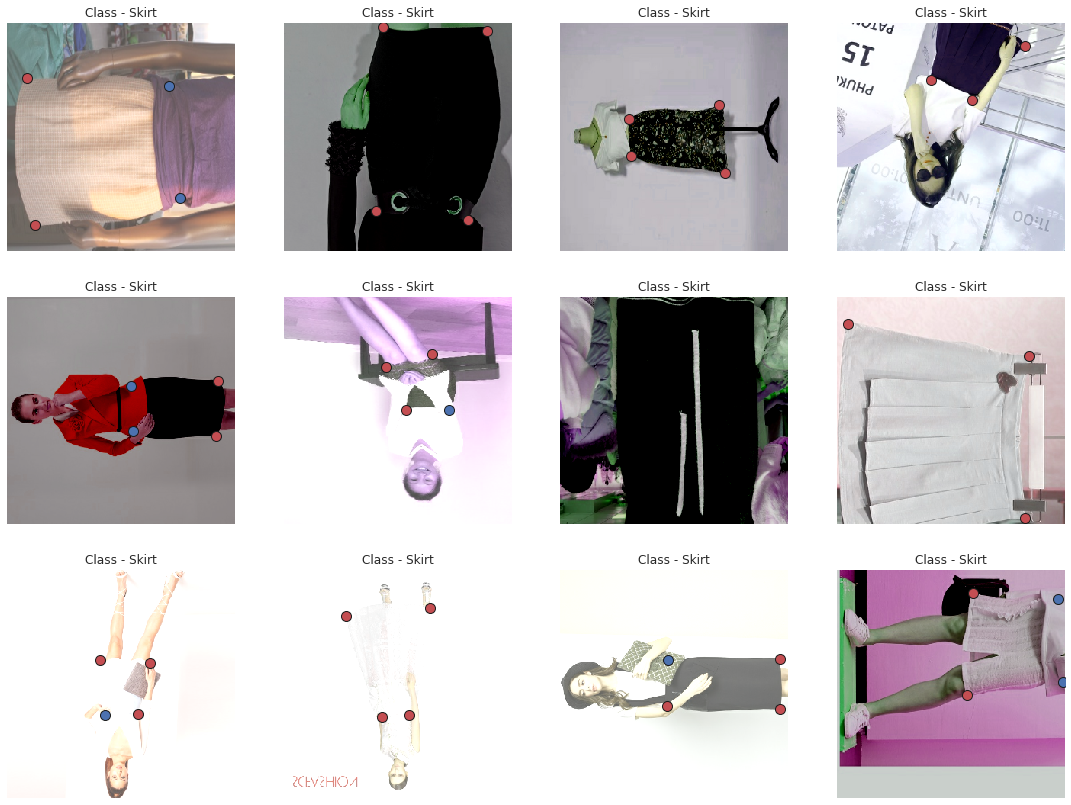

In [76]:
plot_dataset(train_dataset, 3, 4)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_data,
    x=feature_cols,
    y=keypoint_cols,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    prefetch=tf.data.experimental.AUTOTUNE,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
val_dataset_steps = math.ceil(val_dataset_length / val_batch_size)

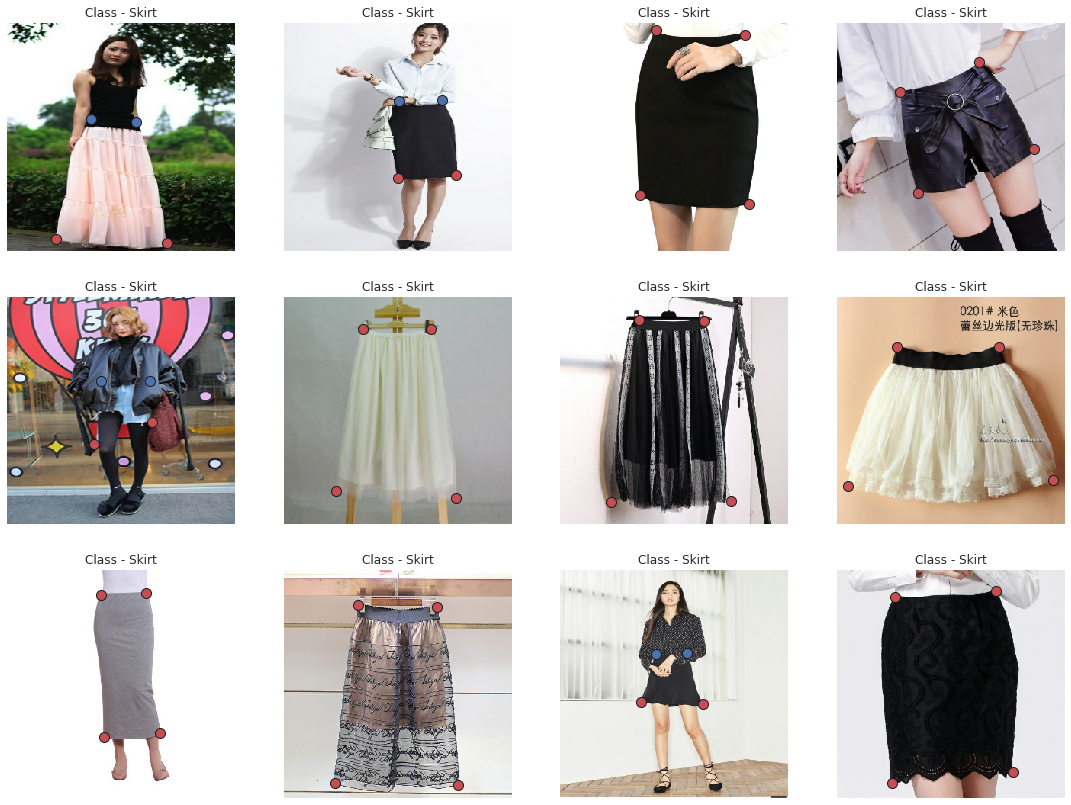

In [78]:
plot_dataset(val_dataset, 3, 4)

## ***Building Model***

### ***Utilities & Setup***

In [0]:
def plot_history(history, contains, skip=0):
    _, ax = plt.subplots(1, len(contains), figsize=(19, 4.75))

    df = pd.DataFrame(history.history)
    for idx, item in enumerate(contains):
        ax[idx].plot(df[list(df.filter(regex=item))].iloc[skip:])
        ax[idx].set_title(item)

In [0]:
def model_capture(model, name, history, save_model=False, load_model=False):
    # Setting variables
    name = name.strip().replace(' ', '_').lower()
    architecture_path = str(Path(MODEL_DIR/f'{name}_weights.h5'))
    weights_path = str(Path(MODEL_DIR/f'{name}_arch.json'))
    history_path = str(Path(MODEL_DIR/f'{name}_hist.csv'))

    # Saving model weights and architecture into the files
    if save_model:
        model.save_weights(weights_path)
        with open(architecture_path, "w") as f:
            f.write(model.to_json())
        
        pd.DataFrame(history.history).to_csv(path_or_buf=history_path, index=False, header=True)
    
    # Loading model weights and architecture from the files
    if load_model:
        with open(architecture_path, "r") as f:
            model = tf.keras.models.model_from_json(f.read())
        model.load_weights(weights_path)
    
    return model

In [0]:
IMG_DIMS = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
CLASS_DIMS = encoder.categories_[0].shape
KEYPOINT_DIMS = (len(anno_cols), 4)

DROPOUT = 0.2
LEARN_RATE = 3e-4
L1_RATE = 1e-5
L2_RATE = 1e-6

EPOCHS = 50
PATIENCE = min(max(EPOCHS // 10, 3), 5)

In [0]:
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
    tf.keras.callbacks.EarlyStopping(patience=int(PATIENCE * 2.5), restore_best_weights=True),
    tf.keras.callbacks.TerminateOnNaN(),
]

### ***Deep Learning Model***

In [0]:
def make_model(input_dims, output_dims, dropout, l1, l2):
    img_dims, class_dims = input_dims
    n_keypoints, n_params = output_dims
    image_input = tf.keras.layers.Input(shape=img_dims)
    class_input = tf.keras.layers.Input(shape=class_dims)

    imagenet = efn.EfficientNetB3(include_top=False, weights='imagenet')(image_input)
    
    img_x = tf.keras.layers.concatenate([
                tf.keras.layers.GlobalAvgPool2D()(imagenet),
                tf.keras.layers.GlobalMaxPool2D()(imagenet),
    ])
    img_x = tf.keras.layers.BatchNormalization()(img_x)
    img_x = tf.keras.layers.Dropout(dropout)(img_x)

    img_dense = tf.keras.layers.Dense(
        2048,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(img_x)
    img_dense = tf.keras.layers.BatchNormalization()(img_dense)
    img_dense = tf.keras.layers.Dropout(dropout)(img_dense)

    img_dense = tf.keras.layers.Dense(
        2048,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(img_dense)
    img_dense = tf.keras.layers.BatchNormalization()(img_dense)
    img_dense = tf.keras.layers.Dropout(dropout)(img_dense)

    keypoint_x = tf.keras.layers.concatenate([img_dense, class_input])
    # keypoint_x = tf.keras.layers.concatenate([img_x, class_input])
    keypoint_x = tf.keras.layers.BatchNormalization()(keypoint_x)
    keypoint_x = tf.keras.layers.Dropout(dropout)(keypoint_x)

    keypoint_output = tf.keras.layers.Dense(
        n_keypoints * n_params,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2),
        activation=tf.keras.activations.sigmoid,
    )(keypoint_x)
    keypoint_output = tf.keras.layers.Reshape(
        output_dims,
    )(keypoint_output)

    model = tf.keras.Model(inputs=[image_input, class_input], outputs=keypoint_output)

    return model

In [84]:
model = make_model(
    input_dims=(IMG_DIMS, CLASS_DIMS),
    output_dims=KEYPOINT_DIMS,
    dropout=DROPOUT,
    l1=L1_RATE,
    l2=L2_RATE,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b3 (Model)         multiple             10783528    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1536)         0           efficientnet-b3[1][0]            
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1536)         0           efficientnet-b3[1][0]            
______________________________________________________________________________________________

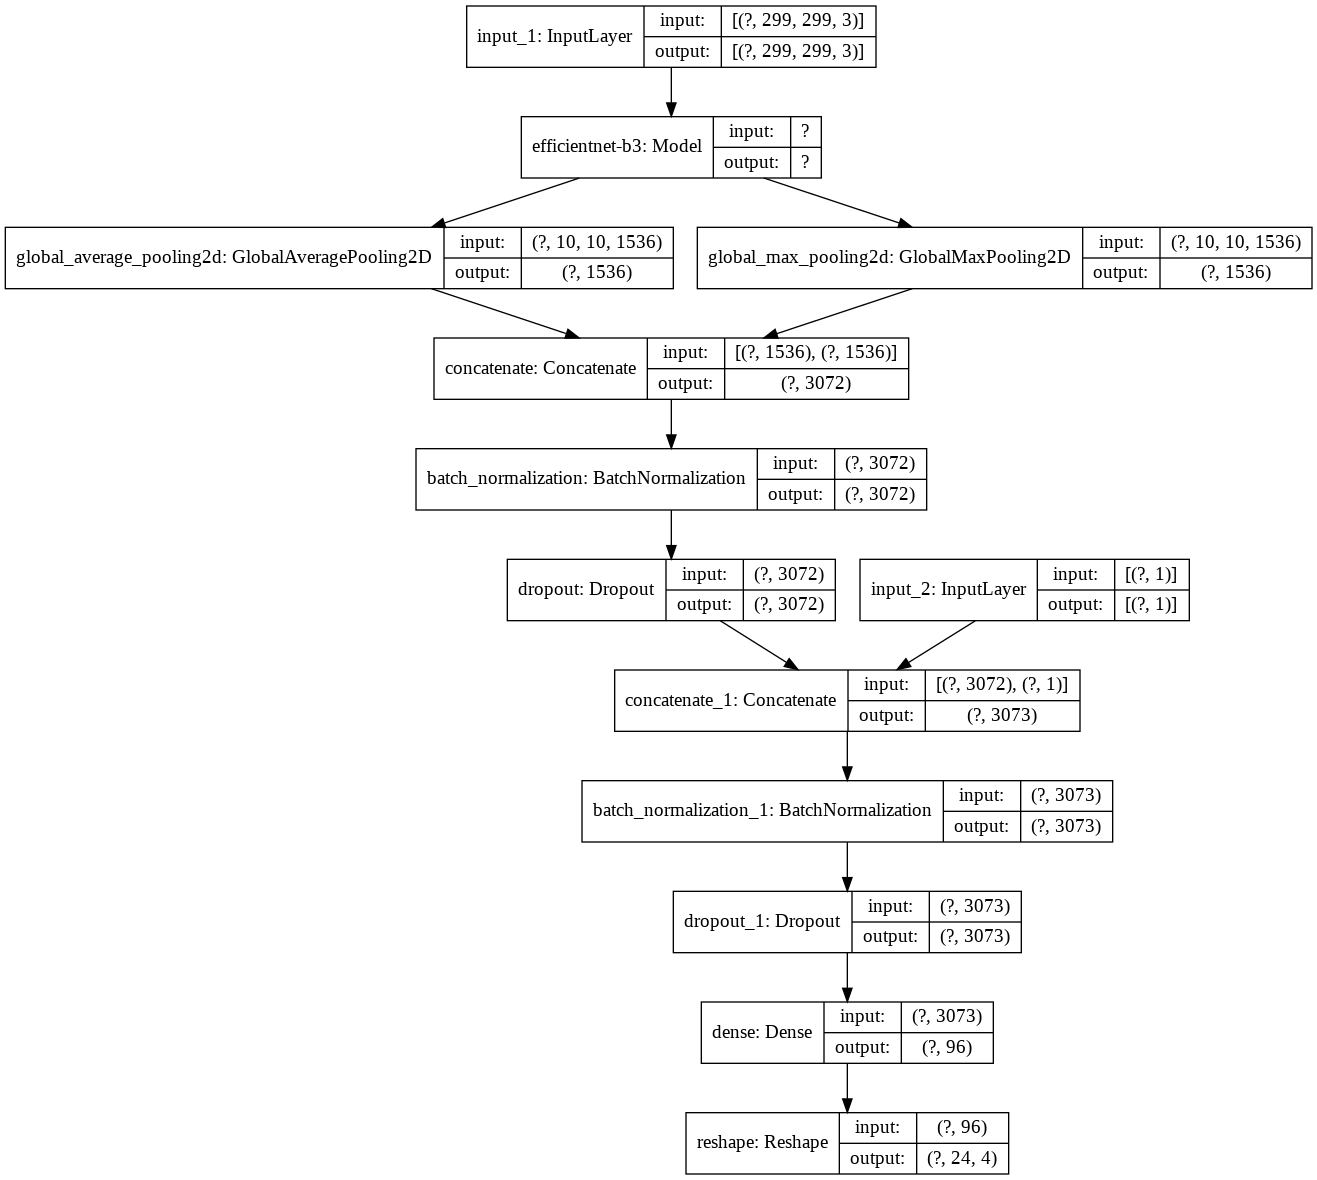

In [85]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARN_RATE),
    loss=[tf.keras.losses.mse],
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [87]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Train for 414 steps, validate for 52 steps
Epoch 1/25
414/414 [==============================] - 318s 768ms/step - loss: 0.4223 - binary_accuracy: 0.8088 - val_loss: 0.1526 - val_binary_accuracy: 0.9114
Epoch 2/25
414/414 [==============================] - 288s 695ms/step - loss: 0.1531 - binary_accuracy: 0.9150 - val_loss: 0.1361 - val_binary_accuracy: 0.9101
Epoch 3/25
414/414 [==============================] - 285s 690ms/step - loss: 0.1318 - binary_accuracy: 0.9179 - val_loss: 0.1198 - val_binary_accuracy: 0.9111
Epoch 4/25
414/414 [==============================] - 287s 694ms/step - loss: 0.1179 - binary_accuracy: 0.9193 - val_loss: 0.1074 - val_binary_accuracy: 0.9123
Epoch 5/25
414/414 [==============================] - 287s 693ms/step - loss: 0.1076 - binary_accuracy: 0.9201 - val_loss: 0.0996 - val_binary_accuracy: 0.9122
Epoch 6/25
414/414 [==============================] - 285s 688ms/step - loss: 0.1000 - binary_accuracy: 0.9207 - val_loss: 0.0932 - val_binary_accuracy: 0.91

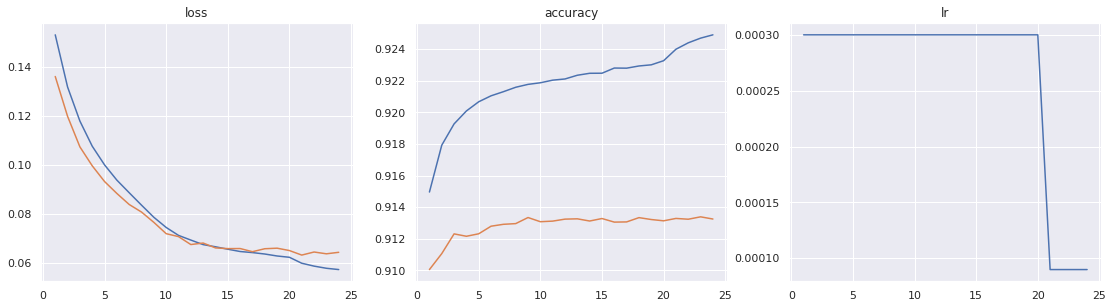

In [101]:
plot_history(model_history, ['loss', 'accuracy', 'lr'], skip=1)

In [89]:
model.evaluate(val_dataset, steps=val_dataset_steps)

52/52 [==============================] - 6s 120ms/step - loss: 0.0643 - binary_accuracy: 0.9133


[0.06433325354009867, 0.9132554]

In [0]:
model_name = 'Keypoints'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history, save_model=True, load_model=True)

In [0]:
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARN_RATE),
    loss=[tf.keras.losses.BinaryCrossentropy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [92]:
loaded_model.evaluate(val_dataset, steps=val_dataset_steps)

52/52 [==============================] - 9s 164ms/step - loss: 0.0643 - binary_accuracy: 0.9133


[0.06433325354009867, 0.9132554]

In [0]:
def plot_predict_dataset(model, dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(4.75 * cols, 4.75 * rows))
    ds = dataset.take(1)
    z = model.predict(ds)
    for (x1, x2), y in ds:
        for i in range(rows * cols):
            image, category = x1[i], x2[i]
            category = encoder.categories_[0][category.numpy().argmax()]
            idx = i // cols, i % cols if rows > 1 else i % cols
            ax[idx].axis('off')
            ax[idx].set_title(f'Class - {category.title()}')
            ax[idx].imshow(image)
            for point in y[i]:
                if point[3]:
                    color = 'ro' if point[2] else 'bo'
                    ax[idx].plot(
                        point[0] * IMG_SIZE, point[1] * IMG_SIZE,
                        color, markersize=10, markeredgecolor='k'
                    )
            for point in z[i]:
                if point[3] > 0.5:
                    color = 'y*' if point[2] > 0.5 else 'c*'
                    ax[idx].plot(
                        point[0] * IMG_SIZE, point[1] * IMG_SIZE,
                        color, markersize=12, markeredgecolor='k'
                    )

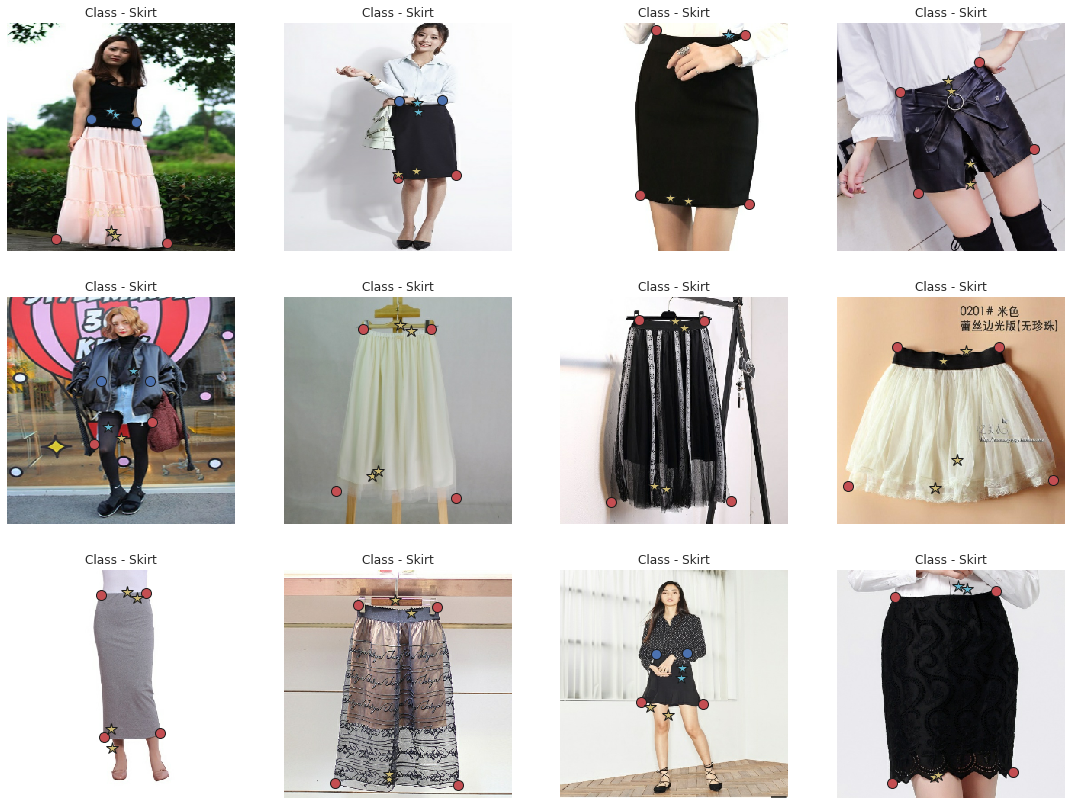

In [94]:
plot_predict_dataset(loaded_model, val_dataset, 3, 4)

In [0]:
preds = model.predict(val_dataset)

In [99]:
preds.shape

(1652, 24, 4)

In [100]:
print(preds)

[[[0.0004647  0.00046309 0.0004661  0.00046787]
  [0.00046859 0.00046182 0.00046241 0.00046488]
  [0.00046377 0.00045661 0.00046817 0.00046312]
  ...
  [0.0004622  0.00046758 0.00046737 0.00046591]
  [0.00046423 0.00046555 0.00046253 0.00047326]
  [0.00045919 0.00046436 0.00046746 0.00046244]]

 [[0.00035696 0.00035548 0.00035827 0.00035555]
  [0.00035369 0.00035154 0.00035398 0.00035418]
  [0.00035158 0.00035165 0.00035317 0.00035257]
  ...
  [0.00035588 0.00035444 0.00035734 0.0003553 ]
  [0.00035404 0.00035217 0.00035533 0.00035245]
  [0.00035309 0.00035449 0.0003555  0.00035459]]

 [[0.00039398 0.00039439 0.00039621 0.00039285]
  [0.00039386 0.00039126 0.00039314 0.00038994]
  [0.00039292 0.00039285 0.00039153 0.00039229]
  ...
  [0.00039378 0.00039108 0.00039572 0.00039351]
  [0.00039443 0.00039088 0.00039563 0.00038866]
  [0.00039257 0.00039219 0.00039348 0.00039182]]

 ...

 [[0.00033576 0.00033337 0.00033208 0.00033314]
  [0.00033239 0.00033144 0.00033466 0.00033483]
  [0.00033

## ***The End***